# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

** HINT: ** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [2]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data[data['income'] == ">50K"].shape[0]

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data[data['income'] == "<=50K"].shape[0]

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k/(n_records * 1.0) * 100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

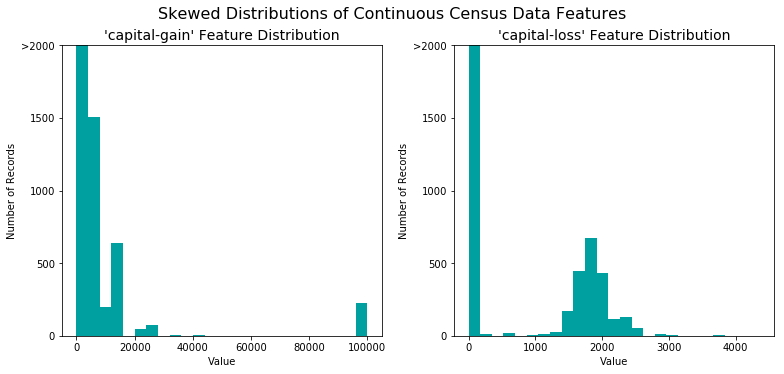

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

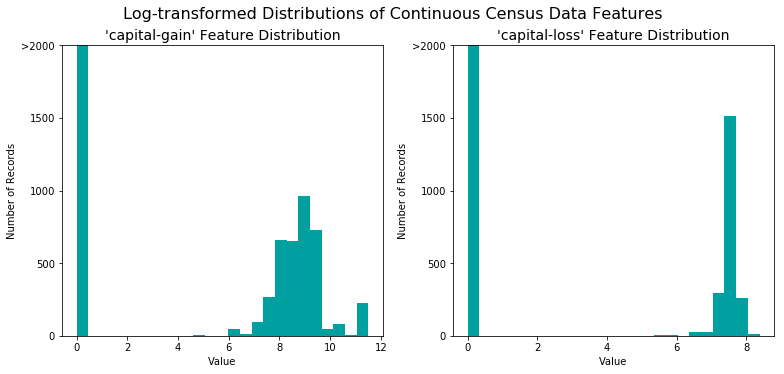

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_log_minmax_transform'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [6]:
# TODO: One-hot encode the 'features_log_minmax_transform' data using pandas.get_dummies()
features_final = pd.get_dummies(features_log_minmax_transform)

# TODO: Encode the 'income_raw' data to numerical values
income = [0 if i == "<=50K" else 1 for i in income_raw]

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
print(encoded)

103 total features after one-hot encoding.
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation_ A

### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [7]:
# Import train_test_split
from sklearn.cross_validation import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


C:\Users\ktost\Anaconda3\envs\py27\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 


#### Note: Recap of accuracy, precision, recall

** Accuracy ** measures how often the classifier makes the correct prediction. It’s the ratio of the number of correct predictions to the total number of predictions (the number of test data points).

** Precision ** tells us what proportion of messages we classified as spam, actually were spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all positives(all words classified as spam, irrespective of whether that was the correct classificatio), in other words it is the ratio of

`[True Positives/(True Positives + False Positives)]`

** Recall(sensitivity)** tells us what proportion of messages that actually were spam were classified by us as spam.
It is a ratio of true positives(words classified as spam, and which are actually spam) to all the words that were actually spam, in other words it is the ratio of

`[True Positives/(True Positives + False Negatives)]`

For classification problems that are skewed in their classification distributions like in our case, for example if we had a 100 text messages and only 2 were spam and the rest 98 weren't, accuracy by itself is not a very good metric. We could classify 90 messages as not spam(including the 2 that were spam but we classify them as not spam, hence they would be false negatives) and 10 as spam(all 10 false positives) and still get a reasonably good accuracy score. For such cases, precision and recall come in very handy. These two metrics can be combined to get the F1 score, which is weighted average(harmonic mean) of the precision and recall scores. This score can range from 0 to 1, with 1 being the best possible F1 score(we take the harmonic mean as we are dealing with ratios).

### Question 1 - Naive Predictor Performace
* If we chose a model that always predicted an individual made more than $50,000, what would  that model's accuracy and F-score be on this dataset? You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

** HINT: ** 

* When we have a model that always predicts '1' (i.e. the individual makes more than 50k) then our model will have no True Negatives(TN) or False Negatives(FN) as we are not making any negative('0' value) predictions. Therefore our Accuracy in this case becomes the same as our Precision(True Positives/(True Positives + False Positives)) as every prediction that we have made with value '1' that should have '0' becomes a False Positive; therefore our denominator in this case is the total number of records we have in total. 
* Our Recall score(True Positives/(True Positives + False Negatives)) in this setting becomes 1 as we have no False Negatives.

In [8]:
'''
TP = np.sum(income) # Counting the ones as this is the naive case. Note that 'income' is the 'income_raw' data 
encoded to numerical values done in the data preprocessing step.
FP = income.count() - TP # Specific to the naive case

TN = 0 # No predicted negatives in the naive case
FN = 0 # No predicted negatives in the naive case
'''

# TODO: Calculate accuracy, precision and recall
n_predictions = len(y_train)
predictions = np.ones(n_predictions)

TP = np.sum(y_train)
FP = n_predictions - TP
FN = 0

# Alternatively, accuracy_score could be used
# from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(Y_train, predictions)
accuracy = np.sum(y_train)/(n_predictions * 1.0)
recall = TP/(TP + FN * 1.0)
precision = TP/(TP + FP * 1.0)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
# HINT: The formula above can be written as (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)
beta = 0.5
fscore = (1 + beta**2) * ((precision * recall)/((beta**2 * precision) + recall))

# Print the results 
print "Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore)

Naive Predictor: [Accuracy score: 0.2489, F-score: 0.2929]


###  Supervised Learning Models
**The following are some of the supervised learning models that are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen

- Describe one real-world application in industry where the model can be applied. 
- What are the strengths of the model; when does it perform well?
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

** HINT: **

Structure your answer in the same format as above^, with 4 parts for each of the three models you pick. Please include references with your answer.

**Answer: **

## Question 2

### General Observations About the Data
In selecting candidate algorithms for modelling, the following observations were made about the CharityML data:

- There are approximately 45K records in total, which is neither very small or very large for a typical Machine Learning problem. Still, some algorithms may perform poorly in some respect (e.g. training/prediction speed) with this number of records (e.g. K-Nearest Neighbour, Support Vector Machine) [17 Chapter 2, section 2.1 p19],[22].
- There are approximately 100 features in the training and testing data after transforming, scaling and normalising the original data. Again, this isn't felt to be a large number of features for a typical data set. However, some features such as *marital-status* and *relationship*, or perhaps *education-level* and *education_num* may be co-related (co-linear?) and one of each pair could be interpreted as redundant information. If so, these extraneous features may contribute noise and/or little useful information for training a model. For an algorithm sensitive to dimensionality (such as K-Nearest Neighbour), these extra dimensions could lower the performance of the algorithm [1].
- Following on from the observations noted above about the data, the problem domain itself suggests there is a fair amount of dependence among the variables. For example, feeatures such as education and salary are typically well correlated with each other, as is occupation and salary. An algorithm such as Naive Bayes may not perform as well at predictions as others due to this feature dependence [4].
- The number of features does not exceed the number of training samples available. The ratio of samples to features is approximately 450:1. Most of the algorithms should be able to handle this number of features and dimensionality without trouble, therefore there may be no discernible advantage to selecting an algorithm that performs well on low sample/high dimension data sets such as Support Vector Machines [22].

### Ensemble Methods
Ensemble models combine the outputs and decision-making strengths of multiple trained models with the goal of improving or increasing overall output accuracy. Ensemble models have greater prediction accuracy than any one model comprising the ensemble. The technique uses strategies such as weighted voting, majority vote, maximum, or some other combination method to compute the final prediction/classification [8],[9],[21].

There are two primary methods of constructing an ensemble: *Bagging* and *Boosting*.

##### Bagging
Bagging involves randomly dividing the training data into subsets, and training a separate model on each subset. The output of all the trained models is combined using strategies such as averaging or majority vote.

**Random Forests**<br/>
Random Forests are an ensemble method consisting of many decision trees. Each decision tree is trained on a different resampling of the original training data. The predictions of the trees in the forest are averaged out to arrive at a single prediction [20].

##### Boosting
Boosting involves the use of a chained sequence of weak classifiers such that the errors and misclassifications of previous classifiers forms part of the training input for the next classifier in the sequence. Each weak learner is reasonably good at learning a small set of features within a subspace of the data set. However, as the output of each learner is fed to subsequent learners, as a whole they learn the entire feature space. Several weak learners are, in effect, combined to form a strong ensemble [8],[9],[12].

**AdaBoost**<br/>
AdaBoost uses weighted majority voting or sum to make final prediction. Incorrect predictions from the previous model are given higher weights for the next model in the sequence in order to priortise the correct fitting of the data at each iteration. As the iterations increase, the most difficult samples are given higher and higher priority through weights than the previously correctly classified samples, thereby training each subsequent model to focus only on the difficult samples. Each model is a weak learner for a subset of the data, with each weak learner in the sequence specialising in harder and harder classification samples misclassified by the previous learners. By default AdaBoost is used with shallow, weak Decision Trees, but in practice could be used with other weak learners [12].

**Gradient Tree Boosting**<br/>
This is an ensemble method that also uses Decision Trees, whereas other Boosting methods such as AdaBoost can utilise other types of models. In contrast to AdaBoost which applies higher weights to the errors from the previous model in the training sequence (encouraging the next model to prioritise the higher-weighted samples), Gradient Boosting approaches things as an optimisation problem, using a differentiable loss function with the goal being to minimise the error in a manner similar to gradient descent [15].

**Real world applications**
- Many real-world problems solved or modelled using a single classifier would typically benefit from an ensemble method. For example, Decision Trees aren't often used alone because the performance of Random Forests and Ensemble models usually exceeds that of a single tree [12]. The most accurate and best-performing algorithms on Kaggle competitions are usually an ensemble variant, the most notable being XGBoost [14].

**Strengths**
- In general, ensembles average out the bias and reduce the variance. Averaging/Majority voting reduces overfitting because each weak classifier in the ensemble is itself unlikely to over-fit, so the combined contributions don't result in overall over-fitting.[7]
- Suitable when the data set is too large to be handled by a single classifier (Divide and Conquer approach by partitioning data among models) [16]
- Useful when decision boundaries too complex or dimensionality of the data too large to produce a single working classifier (e.g. problems with highly non-linear functions) [16]
- Robust to outliers and scales well to larger data sets [4]

**Weaknesses**
- With tree-based ensembles, interpretability is lost due to the averaging/majority vote step used to arrive at the final prediction.

**Justification as a candidate solution**<br/>
An ensemble approach (particularly tree-based ensembles) typically performs better than a single tree, realising most of the benefits of trees while mitigating many of the drawbacks such as overfitting. Ensembles are usually quite fast during training and prediction, scalable and capable of modelling non-linear problems very well [4]. Ensembles are frequently used in data science competitions to achieve top results. [8,9]

### K-Nearest Neighbour
K-Nearest Neighbour (k-NN) is an example of a lazy learning algorithm whereby the training data is itself the model. New predictions are made by computing the similarity of unseen data points through comparisons with the data points in the training data.

k-NN typically uses a distance metric to compute the similarity of data points. To make a prediction, k-NN must calculate the distance of a given unseen instance from all other instances in the model to arrive at a prediction, as well as compute a majority vote or other aggregate function to assign a predicted label or value to the instance. On large datasets and/or high-dimensional features, this can increase the time for training and prediction significantly.

**Real world applications**
- Recommender Systems such as those used by Netflix and Amazon to find movies or products similar to those liked by a user.
- Text and document classification for news articles, to indentify topics, labels or tags that can be applied to a document based on its content.
- Handwriting recognition (digit classification)

**Strengths**
- Insensitive to outliers, no assumptions about the structure of the data [17 Chapter 2, section 2.1 p19]
- Few parameters to tune.
- As an instance-based learner, it is easy to update with new data.
- Suitable for highly non-linear problems, as the kernel function is capable of finding complex non-linear boundaries.[4]

**Weaknesses**
- Speed/Performance: Expensive in terms of memory and computation: memory intensive, computationally expensive [17 Chapter 2, section 2.1 p19]
- Prone to overfitting
- k-NN (instance-based learners) has the following disadvantages [1]:
 - Predictions are expensive, due to the need to store all of the training data and search through all the data.
 - Suffers from the Curse of Dimensionality; high-dimensional features cause the distance metric to determine that all points are far away from each other.
 - If there are many features that are irrelevant and don't contribute much information, or the data contains noisy features, the utility of the distance function is diminished. 

**Justification/Rejection as a candidate solution**<br/>
As an instance-based learner that uses the training data as the model's function, k-NN models can easily incorporate new data into the training data when new information becomes available [1]. It is simply a matter of adding the new training data to the old training data and retraining the model. It's possible to imagine that CharityML would need to frequently update their data and re-train their model. In this case, the instance-based nature of k-NN could be viewed as beneficial to long-term goals, particularly if prediction speed isn't a priority. Considering that the generation of a mailing list may not require fast prediction times and is a relativly infrequent activity I would argue that k-NN deserves to be evaluated further for the simplicity it offers.


### Logistic Regression
Logistic Regression is the counterpart of Linear Regression, but applicable to classification tasks rather than continuous outputs [7]. In particular, the use of the logistic function outputting values (between 0 and 1) that approximate a probability of class membership make Logistic Regression a good binary classification algorithm [18 p172].

**Real world applications**
- Credit scoring [7]

**Strengths**
- Computationally simple and scalable to large data sets [19 p.63]
- Interpretable to some extent by virtue of the coefficients in the function [17 Chapter 5, section 5.2 p84].
- Able to reveal what the important factors and features are in the data that drive the decision-making.

**Weaknesses**
- Prone to overfitting, regularisation is needed to minimise high variance [12]
- Is not suitable for highly non-linear problems; polynomial functions can be used however their power is limited to data that is linearly separable.[12]
- Trained Models can be updated with new data fairly easily. [4]

**Justification/Rejection as a candidate solution**<br/>
Logistic Regression is a popular binary classification algorithm that performs well on a wide variety of problems and scales well to large datasets [13]. As with K-NN, Logistic Regression is a good choice if there is a need to update the model easily because of its computational efficiency and reasonably fast training times.


### References/Bibliography
1. CIS 520: Machine Learning: Fall 09 [Internet]. Learning.cis.upenn.edu. 2009. Available from: http://learning.cis.upenn.edu/cis520_fall2009/index.php?n=Lectures.LocalLearning#toc3
2. Brownlee J. Parametric and Nonparametric Machine Learning Algorithms - Machine Learning Mastery [Internet]. Machine Learning Mastery. 2016. Available from: https://machinelearningmastery.com/parametric-and-nonparametric-machine-learning-algorithms/
3. Srivastava T. Introduction to KNN, K-Nearest Neighbors : Simplified [Internet]. Analytics Vidhya. 2014. Available from: https://www.analyticsvidhya.com/blog/2014/10/introduction-k-neighbours-algorithm-clustering/
4. Modern Machine Learning Algorithms: Strengths and Weaknesses [Internet]. EliteDataScience. 2017. Available from: https://elitedatascience.com/machine-learning-algorithms
5. 1.4. Support Vector Machines — scikit-learn 0.19.0 documentation [Internet]. Scikit-learn.org. 2017. Available from: http://scikit-learn.org/stable/modules/svm.html#multi-class-classification
6. Manning C, Raghavan P, Schütze H. Multiclass SVMs [Internet]. Nlp.stanford.edu. 2008. Available from: https://nlp.stanford.edu/IR-book/html/htmledition/multiclass-svms-1.html
7. James L. The 10 Algorithms Machine Learning Engineers Need to Know [Internet]. Kdnuggets.com. 2016. Available from: http://www.kdnuggets.com/2016/08/10-algorithms-machine-learning-engineers.html
8. Srivastava T. Basics of Ensemble Learning Explained in Simple English [Internet]. Analytics Vidhya. 2015. Available from: https://www.analyticsvidhya.com/blog/2015/08/introduction-ensemble-learning/
9. Ray S. 5 Easy Questions on Ensemble Modeling everyone should know [Internet]. Analytics Vidhya. 2015. Available from: https://www.analyticsvidhya.com/blog/2015/09/questions-ensemble-modeling/
10. Team D. Real-Life Applications of SVM (Support Vector Machines) - DataFlair [Internet]. DataFlair. 2017. Available from: http://data-flair.training/blogs/applications-of-svm/
11. Decision Tree Applications for Data Modelling (Artificial Intelligence) [Internet]. What-when-how.com. 2017. Available from: http://what-when-how.com/artificial-intelligence/decision-tree-applications-for-data-modelling-artificial-intelligence/
12. Getting Up Close and Personal with Algorithms [Internet]. Kdnuggets.com. 2017. Available from: http://www.kdnuggets.com/2017/03/dataiku-top-algorithms.html
13. Brownlee J. Logistic Regression Tutorial for Machine Learning - Machine Learning Mastery [Internet]. Machine Learning Mastery. 2016. Available from: https://machinelearningmastery.com/logistic-regression-tutorial-for-machine-learning/
14. Brownlee J. A Gentle Introduction to XGBoost for Applied Machine Learning - Machine Learning Mastery [Internet]. Machine Learning Mastery. 2016. Available from: https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
15. Brownlee J. A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning - Machine Learning Mastery [Internet]. Machine Learning Mastery. 2016. Available from: https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/
16. Polikar R. Ensemble learning [Internet]. Scholarpedia. 2009. Available from: http://www.scholarpedia.org/article/Ensemble_learning
17. Harrington P. Machine learning in action. Shelter Island: Manning; 2012.
18. McIlwraith D, Marmanis H, Babenko D, Guo Y. Algorithms of the intelligent web. Chapter 5, section 5.2.2. Manning 2009.
19. Brink H, Richards J, Fetherolf M. Real-world machine learning. Chapter 3, section 3.2. Manning 2012.
20. Fortmann-Roe S. Understanding the Bias-Variance Tradeoff [Internet]. Scott.fortmann-roe.com. 2012. Available from: http://scott.fortmann-roe.com/docs/BiasVariance.html
21. 1.11. Ensemble methods — scikit-learn 0.19.0 documentation [Internet]. Scikit-learn.org. 2017. Available from: http://scikit-learn.org/stable/modules/ensemble.html
22. 1.4. Support Vector Machines — scikit-learn 0.19.0 documentation [Internet]. Scikit-learn.org. 2017. Available from: http://scikit-learn.org/stable/modules/svm.html

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [9]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    from sklearn.metrics import accuracy_score, fbeta_score
    samples_300 = 300
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set(X_test),
    #       then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:samples_300])
    end = time() # Get end time
    
    beta = 0.5
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:samples_300], predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:samples_300], predictions_train, beta)
        
    # TODO: Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, beta)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

KNeighborsClassifier trained on 361 samples.
KNeighborsClassifier trained on 3617 samples.
KNeighborsClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
GradientBoostingClassifier trained on 361 samples.
GradientBoostingClassifier trained on 3617 samples.
GradientBoostingClassifier trained on 36177 samples.


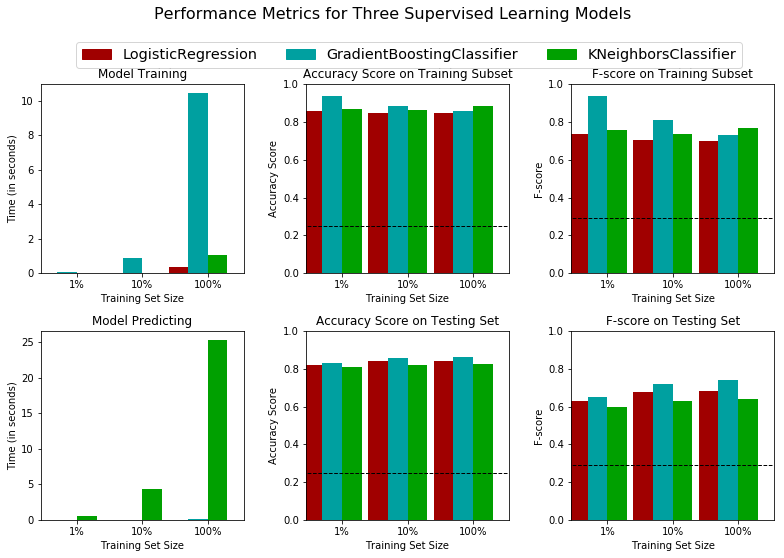

In [10]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# TODO: Initialize the three models
clf_A = KNeighborsClassifier()
clf_B = LogisticRegression(random_state=1)
clf_C = GradientBoostingClassifier(random_state=1)

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
# HINT: samples_100 is the entire training set i.e. len(y_train)
# HINT: samples_10 is 10% of samples_100
# HINT: samples_1 is 1% of samples_100
train_count = len(X_train)
samples_100 = train_count
samples_10 = samples_100/10
samples_1 = samples_10/10

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model

* Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000. 

** HINT: ** 
Look at the graph at the bottom left from the cell above(the visualization created by `vs.evaluate(results, accuracy, fscore)`) and check the F score for the testing set when 100% of the training set is used. Which model has the highest score? Your answer should include discussion of the:
* metrics - F score on the testing when 100% of the training data is used, 
* prediction/training time
* the algorithm's suitability for the data.

**Answer: **<br/>

Examining the graphs above for the three different classifiers, it is clear that the Gradient Tree Boosting (GradientBoostingClassifier) has the highest score in terms of both accuracy and f-score on the test set, particularly when evaluated on 100% of the testing set. Although k-NN outperforms Gradient Boosting on both accuracy and f-score on the *training* subset, the testing subset provides a better measure of the model's generalisation ability. Furthermore, there is a noticeable discrepancy between the k-NN scores on training and testing relative to the other two classifiers, indicating a measureable variance in the model. This variance can be shown by examining the learning curves of the three classifiers using 5-fold cross validation.

![5-Fold Cross Validation](LearningCurves-5FoldCV.png)

As can be seen above, the learning curve graph for k-NN shows a significant gap between the training and testing curves indicating variance and therefore overfitting. In contrast, both curves for Logistic Regression and Gradient Boosting converge together and show higher accuracy, with Gradient Boosting again performing the best overall.

The only drawback to the Gradient Boosting classifier on this data set appears to be the relatively long time required for training the model, taking just less than 10 seconds to train on approximately 36K records. However, once trained the model's predictions are extremely fast, effectively taking no noticeable time at all.

### Question 4 - Describing the Model in Layman's Terms

* In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical jargon, such as describing equations.

** HINT: **

When explaining your model, if using external resources please include all citations.

**Answer: ** <br/>
Gradient Tree Boosting is a classifier algorithm utilising *Ensemble* and *Boosting* techniques to create very robust and fast classification models. Rather than rely on a single well-tuned classifier to model the entire data set, Ensembles are collections of classifiers whose results are combined together to achieve greater precision and accuracy than any single classifier in the model. When considering Ensemble classifiers, one can think of it in terms of the whole being greater than the sum of its parts. Boosting is an Ensemble technique that involves linearly sequencing the ensemble's classifiers such that the outputs of one classifier forms the input to the next classifier in the chain. During training, the errors produced by each classifier are "boosted" by giving them a higher priority to the next classifier in the chain, effectively forcing each classifier to focus on correcting the errors of the previous model. New classifiers are added to the ensemble as required in order to minimise the total error, using an iterative approach. 

This iterative process of optimising and adding classifiers can be computationally intensive and does increases training times. The result however, is a set of classifiers each of which has "specialised" in learning to correctly classify a subset of the original data, and when combined together in sequence the whole ensemble learns the best representation of the entire data set. A trained Gradient Tree Boosting classifier can execute predictions with higher accuracy than many single-model or even other ensemble methods, and does so very quickly due to the use of fast classifiers such as Decision Trees.


### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [11]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score

# TODO: Initialize the classifier
clf = GradientBoostingClassifier(random_state=1)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'max_depth': [2,3,4], 
              'learning_rate': [0.3, 0.4, 0.6, 1],
              'min_samples_split': [2,4,6],
              'criterion': ['friedman_mse', 'mse']}

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

C:\Users\ktost\Anaconda3\envs\py27\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Unoptimized model
------
Accuracy score on testing data: 0.8630
F-score on testing data: 0.7395

Optimized Model
------
Final accuracy score on the testing data: 0.8721
Final F-score on the testing data: 0.7548


### Question 5 - Final Model Evaluation

* What is your optimized model's accuracy and F-score on the testing data? 
* Are these scores better or worse than the unoptimized model? 
* How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  

**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |  0.2489             | 0.8630            | 0.8721          |
| F-score        |  0.2929             | 0.7395            | 0.7548          |


**Answer: **<br/>
Using Grid Search, I've been able to make a small improvement in accuracy and the f-score on my optimised model over that of the unoptimised model. The most pertinent parameters yielding this improvement is setting the *learning_rate* to 0.4 and the *min_samples_split* to 4, while the other parameters remain set to their defaults. Using an iterative approach, I tried various values for a given parameter, and then refined the values further. For example, I tried learning_rates of [0.03, 0.06, 0.09] but none of these yielded improvements. Next, I tried larger values such as [1, 0.6, 0.3] and iteratively found that 0.4 was the ideal number (but kept some other values in the code for illustration).

Similarly, I tested out other parameters such as *criterion* and found that Mean Absolute Error ('mae') took a very long time to run without terminating so I left that out as an option. The *loss* parameter was tested but the default option of 'deviance' outperformed the only other option 'exponential' so I've left that out too.

The accuracy of the optmised model has increased by 0.6232 compared to the naive predictor, which is an approximately 29% improvement. The f-score of the optimised model has increased by 0.4619, a nearly 39% improvement.

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data. Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?

**Answer:**

(In order of importance, most important first)
1. education_level
 - Education is a strong predictor of a person's salary potentional. I would argue that education_num is highly correlated to education_level without providing the level of achievement (e.g. many years of schooling but never obtaining a degree) and is therefore potentially redundant information.
2. occupation
 - The reasoning here is that occupation is expected to be a predictor of salary level. For example, it is generally assumed that professional, executive and managerial occupations have higher salaries than those in retail or trades for example.
3. capital_gain
 - This feature is assumed to indicate forms of income not related to salary. A person with additional forms of income will typically have more disposable income and would likely have a total income over the 50K threshold.
4. marital_status
 - The justification for this feature being important is that from a social perspective, marital status is an indication of characteristics such as financial and social stability. Someone who is married may have an average total household income larger than that of an unmarried person and therefore may have more disposable income for charitable donations. A divorced person may have financial obligations as a result of divorce and may have less disposable income for charitable donations. On the other hand, single persons could be viewed as having more disposable income if they have no children or mortgage obligations. I think the interplay of this feature and others such as occupation and/or education_level would yield interesting results.
5. sex
 - Sex (or perhaps more precisely 'gender') is unfortunately a predictor of salary and income levels, due to many social norms, constructs and practices that affect men and women. On average, women are paid lower salaries than men across most occupations for equal roles. There also exists an imbalance in the number of women occupying senior, managerial and executive roles in many occupations, all of which contributes to lower salaries for women. For these reasons, I would argue that sex would be a reasonable predictor of total income for this data set, particulary as the number of males in the data set is twice that of women. I suppose this has some bearing on the ethical questions surrounding social bias being encoded into machine learning applications and whether such systems are based on ground truths or bias in the data set?


### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

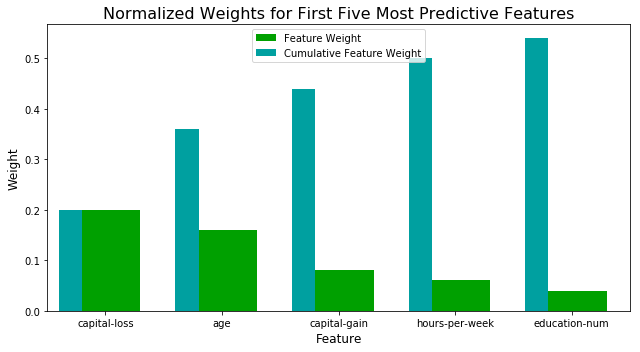

In [12]:
# TODO: Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier

# TODO: Train the supervised model on the training set using .fit(X_train, y_train)
model = AdaBoostClassifier(random_state=1)
model.fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
* How do these five features compare to the five features you discussed in **Question 6**?
* If you were close to the same answer, how does this visualization confirm your thoughts? 
* If you were not close, why do you think these features are more relevant?

**Answer:**

*capital-gain* is the only feature I selected that is present in the graph above. The only other feature that is similar to one of my selections is *education-num*, which I argued wasn't as informative as *education_level*.

In examining the feature importances, the following observations could be made:
1. *capital-loss* would strongly indicate the presence of financial difficulties and a lower income as a result.
2. Older people tend to make higher salaries than younger people.
3. *capital-gain* is a predictor of additional income over and above salary earnings, indicating higher overall salary and increased personal wealth.
4. The length of one's work week is correlated to earnings. Higher earners typically work more hours than average earners, and part-time workers will possibly not have the disposable income for charitable donations.
5. Education strongly correlates with income, though not as strongly as I had assumed nor in the same way (I argued that achievement level was a better predictor).

Taking into consideration that my chosen supervised learning algorithm was an ensemble of trees (Gradient Tree Boosting) it makes sense that the above features play such important roles. The most important feature (*capital-loss*) enables a tree to make a binary choice between those who have capital losses and those that don't (or perhaps some threshold loss value learned from the data), thereby immediately differentiating the two groups of people. The other features are also simple to differentiate on, and most notably, all of the features are numeric. Not a single feature in the top 5 is categorical, in complete contrast to my predicted list of features which was nearly exclusively categorical in nature.

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [13]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8721
F-score on testing data: 0.7548

Final Model trained on reduced data
------
Accuracy on testing data: 0.8426
F-score on testing data: 0.6993


### Question 8 - Effects of Feature Selection

* How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?
* If training time was a factor, would you consider using the reduced data as your training set?

**Answer:**

The reduced model performs worse than both the optimised and unoptimised models.

|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model | Reduced Model   |
| :------------: | :-----------------: | :---------------: | :-------------: | :-------------: |
| Accuracy Score |  0.2489             | 0.8630            | 0.8721          | 0.8426          |
| F-score        |  0.2929             | 0.7395            | 0.7548          | 0.6993          |

The reduced model's accuracy has decreased by 0.0295 and the f-score decreased by 0.0555, dropping by 3.4% and 7.4% respectively in relation to the optmised model. Although the training time using the reduced feature set was much, much quicker than the full feature set, the loss of accuracy and the decrease in f-score (which prioritises precision over recall for this particular domain problem) is in my opinion a less desireable outcome.

I may consider using the reduced feature set as a training option during grid search in order to quickly identify the model parameters that yield increased performance and accuracy.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.